# BEDbla: Boltzmann Enhanced Distributed bla

In [2]:
#Importa los paquetes necesarios
from __future__ import division
#from pylab import *
%pylab inline 
import csv, os, random, sys, shutil, time
from emcee_code import emcee_code_function, modelo
from optparse import OptionParser
from scipy import stats
from scipy import optimize
from optparse import OptionParser
import numpy
numpy.set_printoptions(threshold=numpy.nan)

parser=OptionParser()
tamano=14

Populating the interactive namespace from numpy and matplotlib


In [3]:
#parser.add_option("-i","--input", action="store", type="string", dest="InputFile", help="Path of the .csv input file. Special requirements: The values of the last column will be overwriten. The columns previous to the last one must contain the parameters used for the fitting.")
#parser.add_option("-d", "--threshold", action="store", type="int", dest="Threshold", help="Entries with an activity lower or equal than this value will be considered as active molecules.")
#parser.add_option("-a", "--cactivity", action="store", type="int", dest="NumericActivity", help="Number of the column (starting from 0) that contains the numeric activity of each entry.")
#parser.add_option("-f", "--nbedef", action="store", type="int", dest="NBEDEF", help="Percentage of screened compounds responsible for 80% of BEDEF value.")

#(options, args) = parser.parse_args()

#args_test=["-i", "./BEDHR-Results/Dock"+str(index)+".csv", "-d", "1", "-a", "1", "-f", "20"]
#(options, args) = parser.parse_args(args_test)

In [4]:
inputfile="./BEDHR-Results/MM32.csv" #options.InputFile
inputfile2="./BEDHR-Results/MM34-2.csv"
inputfile3="./BEDHR-Results/Dock41.csv"

thresAct=1 #options.Threshold #Por debajo (o igual) a este valor se considera el compuesto activo
coluMIC=1 #options.NumericActivity
Nbedef=20#options.NBEDEF

#########################################################################################################################

Datos=genfromtxt(inputfile, delimiter=',', skip_header=1) 
Datos2=genfromtxt(inputfile2, delimiter=',', skip_header=1) 
Datos3=genfromtxt(inputfile3, delimiter=',', skip_header=1) 

In [5]:
def arreglar(array):
    filas=len(array[:,0])
    columnas=len(array[0,:])
    array_fix=zeros((filas , columnas+1))
    array_fix[:,1:columnas+1]=array
    
    #Asigna valor boolean a columna 0    
    for o in range(0,filas):
        if (array_fix[o, coluMIC+1]<=thresAct):
            array_fix[o, 0]=1
        if (array_fix[o, coluMIC+1]>thresAct):
            array_fix[o,0]=2
    return array_fix

#Arregla input
DatosArreg=arreglar(Datos)
DatosArreg2=arreglar(Datos2)
DatosArreg3=arreglar(Datos3)

## Enriquecimiento

In [6]:
#Ordena el array de menor a mayor segun los valores de numcol
def Ordenador(array, numcol):
    
    Ordered=array[array[:,numcol].argsort()]
    
    return Ordered

In [7]:
#Crea array con la cantidad de compuestos screened en cada slot
def CompScreened(arrayinp):
    
    compuestos_totales=len(arrayinp[:,0])
    compuestos_screened=1
    porcentaje_screened=zeros(compuestos_totales)
    
    for i in range(compuestos_totales):
        nuevo_procentaje=(compuestos_screened/compuestos_totales)*100
        compuestos_screened +=1
        porcentaje_screened[i]=nuevo_procentaje
        
    return porcentaje_screened

#Crea array con la cantidad de compuestos encontrados hasta cada slot
def ActScreened(array, numcol):
    
    arrayord=Ordenador(array, numcol)
    acttot=0
    actfound=0
    actscreen=zeros(len(array[:,0]))
    
    for h in range(0, len(arrayord[:,0])):
        if (arrayord[h,0] == 1): #Aca se busca el 1 en la columna 0
            acttot += 1
            
    for i in range(0, len(arrayord[:,0])):
        if (arrayord[i, 0] == 1):
            actfound += 1
        actpercent = actfound/acttot * 100
        actscreen[i]=actpercent
        
    return actscreen

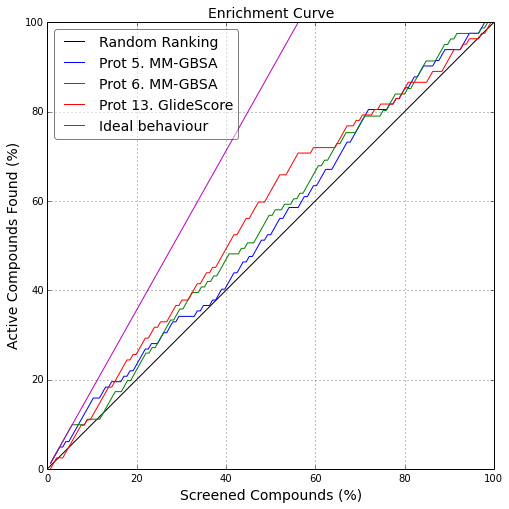

In [21]:
#Grafica curva de enriquecimiento ordenando segun valores de CODE
figure(figsize=(8,8)); hold=True
p=arange(0,101,1)
lin=p
plot(p,lin, 'k-', lw=1, label=r'Random Ranking')
plot(CompScreened(DatosArreg), ActScreened(DatosArreg, len(DatosArreg[0,:])-1), lw=1, label=r'Prot 5. MM-GBSA')
plot(CompScreened(DatosArreg2), ActScreened(DatosArreg2, len(DatosArreg2[0,:])-1), lw=1, label=r'Prot 6. MM-GBSA')
plot(CompScreened(DatosArreg3), ActScreened(DatosArreg3, len(DatosArreg3[0,:])-1), lw=1, label=r'Prot 13. GlideScore')
plot(CompScreened(DatosArreg), ActScreened(DatosArreg, 0), 'm-', lw=1, label=r'Ideal behaviour')
title(r'Enrichment Curve', fontsize=tamano)
xlabel(r'Screened Compounds (%)', fontsize=tamano)
ylabel(r'Active Compounds Found (%)', fontsize=tamano)
legend(fontsize=tamano, fancybox=True, loc=2).get_frame().set_alpha(0.5)
grid()
savefig("EnrichmentCurve5-6-13.png")

#
show()

## BEDHR

In [14]:
def EnrichFacN(screen_array, act_array):
    pend_array=[]
    for i in range (0, len(screen_array)):
        if act_array[i]!=100:
            pendiente=act_array[i]/screen_array[i]
            pend_array.append(pendiente)
        if act_array[i]==100:
            pend_array.append(pendiente)
    return pend_array

pendiente_CODE=EnrichFacN(CompScreened(DatosArreg), ActScreened(DatosArreg, len(DatosArreg[0,:])-1))
pendiente_ideal=EnrichFacN(CompScreened(DatosArreg), ActScreened(DatosArreg, 0))

pendiente_CODE2=EnrichFacN(CompScreened(DatosArreg2), ActScreened(DatosArreg2, len(DatosArreg2[0,:])-1))

pendiente_CODE3=EnrichFacN(CompScreened(DatosArreg3), ActScreened(DatosArreg3, len(DatosArreg3[0,:])-1))

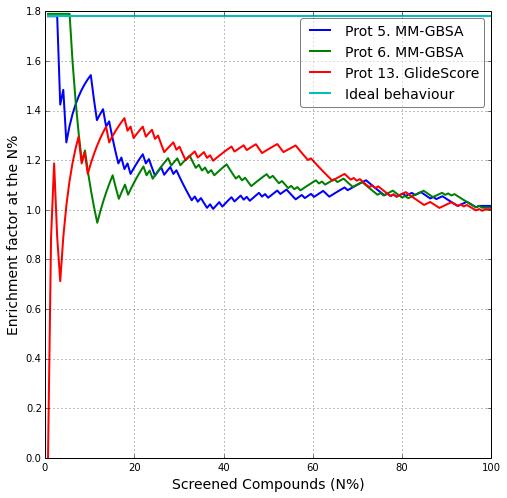

In [16]:
figure(figsize=(8,8)); hold=True
plot(CompScreened(DatosArreg), pendiente_CODE, label="Prot 5. MM-GBSA", lw=2)
plot(CompScreened(DatosArreg2), pendiente_CODE2, label="Prot 6. MM-GBSA", lw=2)
plot(CompScreened(DatosArreg3), pendiente_CODE3, label="Prot 13. GlideScore", lw=2)
plot(CompScreened(DatosArreg), pendiente_ideal, label="Ideal behaviour", lw=2)
xlabel("Screened Compounds (N%)", fontsize=tamano)
ylabel("Enrichment factor at the N%", fontsize=tamano)
legend(fontsize=tamano, fancybox=True, loc=1).get_frame().set_alpha(0.5)
grid()
savefig('EnrichmentFactors5-6-13.png')

#
show()

In [ ]:
def pendiente(screen_array, act_array):
    pend_array=[]
    for i in range (0, len(screen_array)):
        if act_array[i]!=100:
            pendiente=(act_array[i+1]-act_array[i])/(screen_array[i+1]-screen_array[i])
            pend_array.append(pendiente)
        if act_array[i]==100:
            pend_array.append(pendiente)
    return pend_array

pend_inst_code=pendiente(CompScreened(DatosArreg), ActScreened(DatosArreg, len(DatosArreg[0,:])-1))
pend_inst_ideal=pendiente(CompScreened(DatosArreg), ActScreened(DatosArreg, 0))

In [ ]:
figure(figsize=(8,8)); hold=True
plot(CompScreened(DatosArreg), pend_inst_code, label="CODE scoring function")
plot(CompScreened(DatosArreg), pend_inst_ideal, label="Ideal behaviour", lw=2)
xlabel("Screened Compounds (N%)", fontsize=tamano)
ylabel("Instant slope of enrichment curve at N%", fontsize=tamano)
legend(fontsize=tamano, fancybox=True, loc=1).get_frame().set_alpha(0.5)
grid()
#savefig(Nombre + '/' + 'Non-acumulativeEnrichments.png')

#
show()

In [ ]:
def alfacalc(x, Nimp):
    return exp(-x*Nimp/100)-0.8*exp(-x)-0.2

In [ ]:
def bedef(screened_comp, Nimp):
    
    bedef=0
    
    alfa = optimize.brentq(alfacalc, 0.0001, 1000000, args=(Nimp))
    
    weight=exp(-alfa*screened_comp/100)
    bedef_temp=dot(weight, pend_inst_code)
    norm=dot(weight, pend_inst_ideal)
    bedef=bedef_temp/norm
    return bedef

BEDEF20=bedef(CompScreened(DatosArreg), 20)
BEDEF5=bedef(CompScreened(DatosArreg), 5)
BEDEF1=bedef(CompScreened(DatosArreg), 1)
BEDEFN=bedef(CompScreened(DatosArreg), Nbedef)
print BEDEFN

## Log File

In [ ]:
arch = open('BEDHR-Results/BEDHR.log', "a")
    
arch.write('\n \n Input file: ' + inputfile)

arch.write('\n BEDHR(20%): ' + str(BEDEF20))
arch.write('\n BEDHR(5%): ' + str(BEDEF5))
arch.write('\n BEDHR(1%): ' + str(BEDEF1))
arch.write('\n BEDHR(' + str(Nbedef) + '%): ' + str(BEDEFN))

arch.close()
    
msj='All the information regarding this calculation and its results was saved to directory BEDHRResults '
print msj